# Adding Early Stopping Regularization to apparatus-3

## Objectives

- ~~Switch from `read` to `read_up_to` for (hopefully) faster reading~~ \**This didn't work out so well. See apparatus-4-read_up_to-attempt.ipynb.*
- Early-stopping regularization
- ~~TensorBoard summaries of validation loss~~ \**Ran into trouble with this one too (maybe from mixing queue runners with placeholders?).  See apparatus-4-validation_summary_attempt.ipynb.*
- Replace tf.train.Supervisor (since it's unofficially deprecated) with the more primitive classes and functions (like Chip Huyen does):
    - tf.Session
    - tf.train.write_graph()
    - tf.summary.FileWriter
    - tf.train.Saver

From apparatus-3 we inherit the following:
- Logistic Regression with 
- Pausable/reloadable sessions using `tf.train.Supervisor.managed_session()`
- High-volume CSV Input Pipeline.
- TensorBoard monitoring

As in previous apparatuses, I've removed some of the leftover bulk (explanation and sanity-test print() statements) so that the new additions are easier to see.

## The Input Pipeline

In [1]:
import os
import numpy as np
import tensorflow as tf
DATA_DIR = 'bigcluster_parted/'
TRAINING_DIR = os.path.join(DATA_DIR, 'train')
VALIDATION_DIR = os.path.join(DATA_DIR, 'validation')
g = tf.Graph()

### Mini-batch Design Matrix

Get the list of .csv files in the training directory.

In [2]:
training_file_list = [os.path.join(TRAINING_DIR, x) for x in os.listdir(TRAINING_DIR) if x.endswith('.csv')]

Add operations to the graph which prepare mini-batches.

In [3]:
BATCH_SIZE = 50

with g.as_default():
    
    # Create a queue of the filenames
    filename_queue = tf.train.string_input_producer(training_file_list)

    # (if there are lines of metadata at the top of the file, we can skip them using this parameter)
    reader = tf.TextLineReader(skip_header_lines=0)
    
    # Create graph operations to read a line from a CSV file (key is optional, but yields good info)
    key, line_from_file = reader.read(filename_queue)
    
    # Specify the default field values (in case they're missing) and their type
    record_defaults = [[0.5], [0.5], [tf.to_int32(0)]]
    
    # Parse the CSV string into an example tensor [x, y, label]
    example = tf.decode_csv(line_from_file, record_defaults=record_defaults)
    
    # Split the example into a feature vector and a label.
    # Add the extra 1 so we can apply bias via matrix multiplication (this extra 1 used to be right in the CSV file)
#     features = example[:2] + [1.0]
    features = tf.stack([example[0], example[1], tf.ones([], tf.float32)], axis=0)
    label = example[-1]
    
    # Graph operations that produce a mini-batch (key batch is optional)
    key_batch, data_batch, label_batch = tf.train.shuffle_batch(
        [key, features, label], 
        batch_size=BATCH_SIZE, 
        capacity=400, 
        min_after_dequeue=100)

#### Quick check that the extra 1 is added properly

In [4]:
# with tf.Session(graph=g) as s:
#     s.run(tf.global_variables_initializer())
#     coord = tf.train.Coordinator()
#     threads = tf.train.start_queue_runners(coord=coord, sess=s)
    
#     for i in range(20):
#         print("i = " + str(i))
#         for j in range(BATCH_SIZE):
#             print(s.run([data_batch[j], label_batch[j]]))

#     coord.request_stop()
#     coord.join(threads)

### Validation Set *[NEW]*

In [5]:
valdn_file_list = [os.path.join(VALIDATION_DIR, x) for x in os.listdir(VALIDATION_DIR) if x.endswith('.csv')]
valdn_data = np.zeros((0,3), dtype=np.float32)
for f in valdn_file_list:
    file_rows = np.genfromtxt(f, delimiter=',', dtype=np.float32)
    valdn_data = np.concatenate((valdn_data, file_rows))     
valdn_features = np.concatenate((valdn_data[:,:2], np.ones((valdn_data.shape[0],1))), axis=1)
valdn_labels = valdn_data[:,2]

## Logistic Regression

See `apparatus-2.ipynb` for discussion of the math behind logistic regression with stochastic gradient descent.

### Trainable Parameters: $\boldsymbol \theta = (\theta_0, \theta_1, \theta_2) \in \mathbb R^3$

In [6]:
with g.as_default():
    theta = tf.get_variable(name="theta", 
                            shape=[3], 
                            initializer=tf.random_normal_initializer(mean=0, stddev=1, seed=None, dtype=tf.float32),
                            dtype=tf.float32)
    print(theta)

<tf.Variable 'theta:0' shape=(3,) dtype=float32_ref>


Let's do a quick check to make sure theta looks right when it's initialized.  If you get all zeroes, check the console for error messages.  Sometimes it fails to allocate GPU memory for whatever reason. 

In [7]:
with tf.Session(graph=g) as s:
    tf.global_variables_initializer().run()  # Necessary?  Yes!  This is how theta gets initialized
    print(s.run([theta]))

[array([ 0.64841515, -0.05896103,  1.24947178], dtype=float32)]


### Training Operation

In [8]:
learning_rate = 0.1  # Aggressive learning rate for expidiency (since this is just a demo)
with g.as_default():

    # Step counter
    global_step = tf.Variable(0, name="global_step", trainable=False, dtype=tf.int32)

    # NEW: decaying learning rate!
#     learning_rate = 0.01 * 0.99 ** tf.cast(global_step / 100000, tf.float32)

    # Compute the hidden layer output (pre-sigmoid function)
    logits = tf.reshape(tf.matmul(data_batch, theta[:,None]), [-1])
    
    # Compute the loss of each example in the mini-batch
    losses = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.cast(label_batch, tf.float32), logits=logits)
    
    # Find the mean loss of the mini-batch
    loss = tf.reduce_mean(losses)
    
    # NEW: Let's calculate a more human-readable loss measurement!
    predictions = tf.maximum(0.0, tf.sign(logits))
    proportion_misclassified = tf.reduce_sum(tf.squared_difference(tf.cast(label_batch, tf.float32), predictions)) / tf.cast(predictions.shape[0], tf.float32)
    
    # Train Op
    train_op = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss, global_step=global_step)

### Validation Operation

In [9]:
def make_batch(data, max_size, batch_num):
    n = data.shape[0]
    offset = (batch_num * max_size) % n
    return data[offset:offset+max_size]

GPU_VALIDATION_BATCH_SIZE_MAX = 20
with g.as_default():
    tf_valdn_features = tf.placeholder(tf.float32, shape=(GPU_VALIDATION_BATCH_SIZE_MAX,3))  # (x,y,1)
    tf_valdn_labels   = tf.placeholder(tf.float32, shape=(GPU_VALIDATION_BATCH_SIZE_MAX))
    tf_valdn_logits   = tf.matmul(tf_valdn_features, theta[:,None])[:,0]

#     # CREATE tf_valdn_loss: need a tf variable to hold the validation loss for a summary
#     with tf.variable_scope('summaries'):
#         tf_valdn_loss = tf.get_variable(name="tf_valdn_loss",
#                                         shape=(1),
#                                         trainable=False,
#                                         initializer=tf.constant_initializer(1.0), 
#                                         dtype=tf.float32)

def valdn_loss(tf_session):
    loss = 0
    valdn_size = valdn_features.shape[0]
    valdn_eg_weight = 1.0 / np.float32(valdn_size)
    n_batches = int(np.ceil(valdn_features.shape[0] / GPU_VALIDATION_BATCH_SIZE_MAX))
    for i in range(n_batches):
        vald_feature_batch = make_batch(valdn_features, GPU_VALIDATION_BATCH_SIZE_MAX, i)
        vald_label_batch = make_batch(valdn_labels, GPU_VALIDATION_BATCH_SIZE_MAX, i)
        feed_dict = {tf_valdn_features: vald_feature_batch, tf_valdn_labels: vald_label_batch}
        
        # This is gives us a vector of length batch_size containing the cross entropy loss of each example in the batch
        batch_size = vald_feature_batch.shape[0]
        batch_vlosses = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.cast(vald_label_batch, tf.float32), 
            logits=tf_valdn_logits)
        bv = tf_session.run(batch_vlosses, feed_dict=feed_dict)
        
        # We need to consolidate those into a mean
        batch_weight = valdn_eg_weight * batch_size
        loss += batch_weight * np.mean(bv)
    
#     with tf.variable_scope('summaries', reuse=True):
#         tf_valdn_loss = tf.get_variable(name="tf_valdn_loss")
#         tf_valdn_loss.assign(loss)
    return loss

### TensorBoard Summaries

In [11]:
with g.as_default():
    with tf.variable_scope("summaries", reuse=True):
#         tf.summary.scalar("learning_rate", learning_rate)
        tf.summary.scalar("loss", loss)
        tf.summary.scalar("proportion_misclassified", proportion_misclassified)
        tf.summary.scalar("theta0", theta[0])
        tf.summary.scalar("theta1", theta[1])
        tf.summary.scalar("theta2", theta[2])
        tf.summary.histogram("histogram_loss", loss)
        tf.summary.histogram("histogram_theta0", theta[0])
        tf.summary.histogram("histogram_theta1", theta[1])
        tf.summary.histogram("histogram_theta2", theta[2])
        
#         tf_valdn_loss = tf.get_variable(name="tf_valdn_loss")
#         tf.summary.scalar("validation_loss", tf_valdn_loss)
#         tf.summary.histogram("histogram_validation_loss", tf_valdn_loss)

        # Wrap them all up
        summary_op = tf.summary.merge_all()

In [12]:
with tf.Session(graph=g) as s:
    s.run(tf.global_variables_initializer())
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord, sess=s)
    
    for i in range(500):
        t_op, ls, gstep = s.run([train_op, loss, global_step])
        if (i % 100 == 0):
            print("step %3d:\tloss = %f" % (gstep, ls))

    coord.request_stop()
    coord.join(threads)

step   1:	loss = 0.661168
step 101:	loss = 0.455626
step 201:	loss = 0.322910
step 301:	loss = 0.240308
step 401:	loss = 0.227883


### Training Session

Our queue runners will be sampling stochastically with replacement from the whole pool of input data for each batch.  That means--unlike a scheme in which all the training data is permuted--we don't have proper epochs.  What we'll do instead is measure the size of the pool and take an "epoch" to be simply that many examples (even if some examples are missed while others are sampled more than once during an "epoch" of training).

In [13]:
import subprocess  # need this to run the `wc` utility in bash 
import numpy as np

# Get a string containing the input filenames as a space-delimited list
training_file_list_str = " ".join(training_file_list)

# Find out how many training examples there are, altogether (by counting the lines in the files)
training_pool_size = int(subprocess.check_output("cat " + training_file_list_str + " | wc -l", shell=True).decode('UTF-8'))
batches_per_epoch = int(np.ceil(training_pool_size / BATCH_SIZE))

In [14]:
print(g.get_all_collection_keys())

['summaries', 'queue_runners', 'trainable_variables', 'train_op', 'variables']


In [15]:
print(g.get_collection('trainable_variables'))

[<tf.Variable 'theta:0' shape=(3,) dtype=float32_ref>]


In [16]:
print(*g.get_collection('summaries'), sep='\n')

Tensor("input_producer/fraction_of_32_full:0", shape=(), dtype=string)
Tensor("shuffle_batch/fraction_over_100_of_300_full:0", shape=(), dtype=string)
Tensor("summaries/loss:0", shape=(), dtype=string)
Tensor("summaries/proportion_misclassified:0", shape=(), dtype=string)
Tensor("summaries/theta0:0", shape=(), dtype=string)
Tensor("summaries/theta1:0", shape=(), dtype=string)
Tensor("summaries/theta2:0", shape=(), dtype=string)
Tensor("summaries/histogram_loss:0", shape=(), dtype=string)
Tensor("summaries/histogram_theta0:0", shape=(), dtype=string)
Tensor("summaries/histogram_theta1:0", shape=(), dtype=string)
Tensor("summaries/histogram_theta2:0", shape=(), dtype=string)


This is where we used to have a `managed_session()`.

**BEFORE RUNNING THE NEXT CELL**:
- run `tensorboard --logdir ./apparatus-4 &` in a bash terminal
- Have this command ready to go:
```
touch ./apparatus-4/pause
```

In [17]:
import time
NOTEBOOK_DIR = "apparatus-4"
PAUSE_FILE = os.path.join(NOTEBOOK_DIR, "pause")
CHKPT_FILE = os.path.join(NOTEBOOK_DIR, "model.ckpt")
BEST_MODEL = os.path.join(NOTEBOOK_DIR, "bestmodel.ckpt")
METAGRAPH_NAME = "graph.pb"
EARLY_STOPPING_PATIENCE = 200     # min. epochs without improvement before we stop training
CHKPT_FREQ = 5                    # number of seconds btw saved checkpoints

# NEW: Save the "metagraph" (or, as TensorFlow calls it, the "graph")
g.add_to_collection('theta', theta)
tf.train.write_graph(graph_or_graph_def=g, logdir=NOTEBOOK_DIR, name=METAGRAPH_NAME, as_text=False)

with tf.Session(graph=g) as s:

    # summary_writer feeds TensorBoard
    summary_writer = tf.summary.FileWriter(logdir=NOTEBOOK_DIR, graph=g)

    # One saver for checkpoints, the other for saving the best model so far
    chkpt_saver = tf.train.Saver()
    early_stopping_saver = tf.train.Saver(max_to_keep=3)

    # Must initialize since we're not using managed_seesion
    tf.global_variables_initializer().run()
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord, sess=s)

    # Initialize the training admin variables
    last_chkpt_time = time.time()
    es_timer = EARLY_STOPPING_PATIENCE
    best_vloss = np.inf                    # "positive infinity"
    epochs_since_improvement = 0
    while not tf.gfile.Exists(PAUSE_FILE):
        
        # Train uninterrupted for one epoch
        for i in range(batches_per_epoch):
            t_op, ls, gstep, summary_op_result = s.run([train_op, loss, global_step, summary_op])
        epochs_since_improvement += 1
        
        # Save a checkpoint, validate, and update TensorBoard if it's time to do so
        if (time.time() - last_chkpt_time > CHKPT_FREQ):
            last_chkpt_time = time.time()
            chkpt_saver.save(s, CHKPT_FILE, global_step=gstep)
            summary_writer.add_summary(summary_op_result, global_step=gstep)
            
            # Early Stopping Admin
            vloss = valdn_loss(s)
            if vloss < best_vloss:
                print("* ", end='')
                best_vloss = vloss
                best_step = global_step
                epochs_since_improvement = 0
                early_stopping_saver.save(s, BEST_MODEL, global_step=gstep)
            else:
                if epochs_since_improvement >= EARLY_STOPPING_PATIENCE:
                    print("Validation loss hasn't improved in %d epochs, hence we assume the model has been overtrained.  Stopping..." % epochs_since_improvement)
                    break
            print("step %3d:\ttraining loss = %f \t validation loss = %f" % (gstep, ls, vloss))

    coord.request_stop()
    coord.join(threads)
    
    if tf.gfile.Exists(PAUSE_FILE):
        print("Pause command received.  Saving checkpoint and shutting down.")
        tf.gfile.Remove(PAUSE_FILE)
        saver.save(s, checkpoint_file, global_step=global_step)

* step 600:	training loss = 0.281943 	 validation loss = 0.222903
* step 1248:	training loss = 0.217533 	 validation loss = 0.201745
* step 1896:	training loss = 0.234105 	 validation loss = 0.195038
* step 2532:	training loss = 0.216549 	 validation loss = 0.192104
* step 3168:	training loss = 0.250190 	 validation loss = 0.190558
* step 3792:	training loss = 0.160608 	 validation loss = 0.189663
* step 4404:	training loss = 0.182575 	 validation loss = 0.189150
* step 4992:	training loss = 0.306136 	 validation loss = 0.188757
* step 5604:	training loss = 0.234611 	 validation loss = 0.188376
* step 6204:	training loss = 0.171333 	 validation loss = 0.188241
* step 6780:	training loss = 0.144898 	 validation loss = 0.188122
* step 7308:	training loss = 0.205489 	 validation loss = 0.187911
* step 7884:	training loss = 0.145647 	 validation loss = 0.187856
step 8436:	training loss = 0.177963 	 validation loss = 0.187857
* step 9012:	training loss = 0.203771 	 validation loss = 0.18775

### Pick up where we left off
If you paused the previous cell (before it stopped by itself) note the last reported `step`.  Then run the previous cell again.  Observe that the model resumes training from where it was paused, even if you've rebooted the computer and rerun the notebook.  It will resume as long as the training directory isn't wiped. 

In [1]:
# Kill the kernel, forcing it to restart
import os
#os._exit(0)

## Training Analysis

Get a list of the save files available.

In [1]:
import os

NOTEBOOK_DIR = "apparatus-4"

# Grab the most recent metagraph file
metagraph_files = [os.path.join(NOTEBOOK_DIR, x) for x in os.listdir(NOTEBOOK_DIR) 
                   if (x.startswith('bestmodel') and x.endswith('.meta'))]
metagraph_files.sort()
metagraph_file = metagraph_files[-1]

# Grab the most recent graph file
graph_file = os.path.splitext(metagraph_file)[0]

print(metagraph_file, graph_file)

apparatus-4/bestmodel.ckpt-18000.meta apparatus-4/bestmodel.ckpt-18000


### Plot the trained dividing line

It's nice to see the loss going down, but what does the $\theta$ line actually look like?  To access the last value of $\theta$, we need to retrieve it from a `managed_session` again.

In [2]:
import tensorflow as tf

with tf.Session() as s:
    new_saver = tf.train.import_meta_graph(metagraph_file)
    new_saver.restore(s, graph_file)
    theta = tf.get_collection('theta')
    np_theta = s.run(theta)
print(np_theta)

INFO:tensorflow:Restoring parameters from apparatus-4/bestmodel.ckpt-18000
[array([ 4.54007053,  3.80272532, -4.20728874], dtype=float32)]


TensorFlow has the value of $\theta$ wrapped in a tensor together with its metadata (the type).  The tuple we need is in that first element.

In [3]:
# We'll take left border = -1, right border = 2, top border = 2, bottom border = -1
if np_theta[0][1] == 0:
    l0 = [-np_theta[0][2] / np_theta[0][0], -1]
    l1 = [-np_theta[0][2] / np_theta[0][0], 2]
else:
    l0 = [-1, -(np_theta[0][2] - np_theta[0][0]) / np_theta[0][1]]
    l1 = [2,  -(np_theta[0][2] + 2.0 * np_theta[0][0]) / np_theta[0][1]]

In [4]:
print(l0, l1)

[-1, 2.300287] [2, -1.2814105468248915]


### Read in the CSV files

In [5]:
DATA_DIR = 'bigcluster_parted'
TEST_DIR = os.path.join(DATA_DIR, 'test')
csv_file_list = [os.path.join(TEST_DIR, x) for x in os.listdir(TEST_DIR) if x.endswith('.csv')]

In [6]:
import numpy as np
rows = np.ones(shape=(0,3), dtype=np.float32)
for csvfile in csv_file_list:
    rows = np.append(rows, np.genfromtxt(csvfile, delimiter=','), axis=0)
points = rows[:,:2] 
labels = rows[:,2]

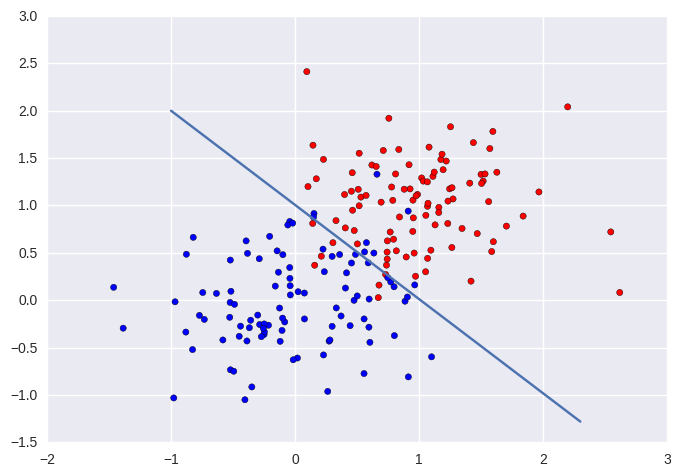

In [7]:
%matplotlib inline
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sns

vec_colour = np.vectorize(lambda x: ['#0000FF','#FF0000'][int(x)])  # Transform the labels to colours
colour_labels = vec_colour(labels)
plt.scatter(points[:,0], points[:,1], c=colour_labels)
#plt.plot([-1,2], [2,-1])  # This is the line we want a classifier to find
plt.plot(l0, l1)
plt.show()

### Next Objectives
- L2 weight decay regularization
- Dropout regularization (once we add some more layers)
- Autoencoder
- LSTM
- LeNet-5
- t-SNE
- PCA
- XGBoost (outside TensorFlow)
- Look at pandas and see whether there's anything helpful in there